## Loading data

In [1]:
# !pip install  albumentations --upgrade

In [ ]:
!git clone https://github.com/kevinkwshin/FootDiagnosis/
%cd FootDiagnosis/

In [2]:
!pip install -U pydicom nibabel monai==0.8.0 kornia
!pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/rich/console.py", line 1368, in render
    renderable = rich_cast(renderable)
  File 

In [3]:
import warnings
warnings.filterwarnings("ignore")

!nvidia-smi
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob, natsort
import pandas as pd

import scipy
import scipy.ndimage

import skimage
import skimage.morphology

import cv2
import torch.nn.functional as F

Tue Nov 29 07:00:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |   8058MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   

In [4]:
from skimage.measure import label, regionprops, regionprops_table
import math
import kornia

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA

# axis method
# 1. PCA
# 2. Minimum Rotational inertia
# 3. Ellipse

def visualize(**images):
    """Plot images in one row."""
    angles = list()
    
    n = len(images)
    plt.figure(figsize=(32, 16))
    for i, (name, image) in enumerate(images.items()):
        if i==0 and image.shape[0] == 3:
            image_main = image.permute(1,2,0).numpy()#.int()
        if torch.is_tensor(image) and image.shape[0] == 3:
            image = image.permute(1,2,0).numpy()#.int()
        else:
            try:
                image = image.numpy()
            except:
                pass
            
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        # plt.title()
        plt.imshow(image_main,cmap='gray')        
        plt.imshow(image,cmap='gray',alpha=0.4)
        if i == 1:
            head = head_direction(image)
        if i>=1:           
            major = True if i <=4 else False
            clockwise_plus = True if i==1 else False
            x0,y0,angle = PCA_axis(image,major)
            # x0,y0,angle = inertia_axis(image,major)
            plt.title(' '.join(name.split('_')).title()+'_PCA : {:.2f} degrees'.format(refine_degree(angle,head,clockwise_plus=clockwise_plus)))
            image = kornia.morphology.opening(torch.tensor(image).unsqueeze(0).unsqueeze(0),torch.ones(5,5))
            image = image.squeeze()
            draw_axis(image_main, image, x0, y0, angle)
    plt.tight_layout()
    plt.show()

def draw_axis(image, mask, x0, y0, radian_degree):
    """
    radian_degree
    """
    length = 320
    
    x1 = x0 + math.cos(radian_degree) * 0.5 * length
    y1 = y0 + math.sin(radian_degree) * 0.5 * length
    x2 = x0 - math.cos(radian_degree) * 0.5 * length
    y2 = y0 - math.sin(radian_degree) * 0.5 * length
    x3 = x0 + math.sin(radian_degree) * 0.5 * length
    y3 = y0 - math.cos(radian_degree) * 0.5 * length
    x4 = x0 - math.sin(radian_degree) * 0.5 * length
    y4 = y0 + math.cos(radian_degree) * 0.5 * length

    plt.imshow(image,cmap='gray')
    plt.imshow(mask,cmap='gray',alpha=0.4)
    plt.contour(mask,colors='#FD8A02',alpha=.5)
    angle = - np.tan((y0 - y2) / (x0 - x2))
    plt.plot((x0, x1), (y0, y1), '#01686D', linewidth=3)
    plt.plot((x0, x2), (y0, y2), '#01686D', linewidth=3)
    plt.plot(x0, y0, '.g', markersize=15)
    

def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum() 

def inertia_axis(data, major):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_bar = m10 / data_sum
    y_bar = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_bar * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_bar * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_bar * m01) / data_sum
    
    if major == True:
        angle = 0.5 * np.arctan(2 * u11 / (u20 - u02))
    else:
        angle = 0.5 * np.arctan(2 * u11 / (u20 - u02)) # + np.pi/2
    
    return x_bar, y_bar, angle

def ellipse_axis(image, major=True):
    try:
        image = image.numpy()
    except:
        pass
    
    image = image.astype(np.uint8)
    regions = regionprops(image)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.sin(orientation) * 0.5 * 300
        y1 = y0 + math.cos(orientation) * 0.5 * 300
        x2 = x0 - math.sin(orientation) * 0.5 * 300
        y2 = y0 - math.cos(orientation) * 0.5 * 300
        x3 = x0 + math.cos(orientation) * 0.5 * 150
        y3 = y0 - math.sin(orientation) * 0.5 * 150
        x4 = x0 - math.cos(orientation) * 0.5 * 150
        y4 = y0 + math.sin(orientation) * 0.5 * 150
        
        if major:
            angle = np.tan((y0 - y2) / (x0 - x2))
        else:
            angle = np.tan((y0 - y3) / (x0 - x3))

    return x0, y0, angle

def PCA_axis(mask_2d,major=True):
    
    mask_2d = np.rot90(mask_2d,2)
    mask_2d = np.flip(mask_2d)
    b= np.nonzero(mask_2d == 1)
    b = np.array(b)
    b = np.transpose(b) 
    b = np.flip(b) 
    X = b
    
#     # visualize
#     plt.axis('equal')
#     plt.scatter(X[:,0],X[:,1]);    

    pca=PCA(2)
    pca.fit(X)

#     print("Principal axes:", pca.components_)
#     print("Explained variance:", pca.explained_variance_)
#     print("Principal axes angle:",angle)
#     print("Mean:", pca.mean_)

    if major == True:
        angle = np.arctan(pca.components_[0][1]/pca.components_[0][0])
    else:
        angle = np.arctan(pca.components_[0][1]/pca.components_[0][0]) - np.pi/2
        
    x0,y0 = pca.mean_
    return x0, y0, angle

def refine_degree(radian, head, clockwise_plus=True):
    while radian <= -np.pi/2:
        radian += np.pi
    while radian >= np.pi/2:
        radian -= np.pi
    
    degree = np.degrees(radian)

    if head=='left' and clockwise_plus==True:
        return degree
    elif head=='right' and clockwise_plus==True:
        return -degree
    elif head=='left' and clockwise_plus==False:
        return -degree
    elif head=='right' and clockwise_plus==False:
        return degree
    
def head_direction(mask_1_2d):
    y,x = mask_1_2d.shape  
    x0,y0,_ = inertia_axis(mask_1_2d,True)
    ratio = x0/x
    if ratio > 0.5: 
        head = 'left'
    else:
        head = 'right'
    return head

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

### Augmentations

In [5]:
# Training & Validation Transform chain
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# from monai.losses import DiceCELoss
# from monai.inferers import sliding_window_inference
# from monai.transforms import *

# from monai.config import print_config
# from monai.metrics import DiceMetric

# from monai.data import (
#     Dataset,
#     DataLoader,
#     CacheDataset,
#     decollate_batch,
# )

# def check(x):
#     print(x.shape, np.unique(x))
#     return x

# prob=0.3
# patch_size= (512,1024)
# train_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "seg"]),
#         # AddChanneld(keys=["image"]),
#         Lambdad(keys='image', func=lambda x: np.transpose(x)),       
#         Lambdad(keys='image', func=lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)),
#         Lambdad(keys='image', func=lambda x: np.moveaxis(x,-1,0)),
#         Lambdad(keys='seg', func=lambda x: np.moveaxis(x,-1,0)),
        
#         # EnsureChannelFirstd(keys=["image", "seg"]),
#         ScaleIntensityRanged(keys=["image"],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True,),
        
#         # Spacingd(
#         #     keys=["image", "seg"],
#         #     pixdim=(1.5, 1.5, 2.0),
#         #     mode=("bilinear", "nearest"),
#         # ),
        
#         RandAdjustContrastd(keys=["image"],gamma=(0.5, 4.5), prob=prob),
#         RandShiftIntensityd(keys=["image"],offsets=(-0.3, 0.3), prob=prob),
#         RandScaleIntensityd(keys=["image"],factors=(-0.3, 0.3), prob=prob),
#         RandStdShiftIntensityd(keys=['image'],factors=(-5, 5), prob=prob),   
#         RandHistogramShiftd(keys=["image"], num_control_points=20, prob=prob),
#         # RandLambdad(keys='image', func=lambda x: 1-x, prob=prob),
#         # ]),
        
#         # OneOf(transforms=[
#         RandGaussianSmoothd(keys=["image"],sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), prob=prob),
#         RandGaussianSharpend(keys=["image"],sigma1_x=(0.5, 1.0), sigma1_y=(0.5, 1.0), sigma1_z=(0.5, 1.0), sigma2_x=0.5, sigma2_y=0.5, sigma2_z=0.5, alpha=(10.0, 30.0), prob=prob),
#         # ]),
            
#         # OneOf(transforms=[
#         RandGaussianNoised(keys=["image"],mean=0.0, std=0.1,prob=prob),
#         RandBiasFieldd(keys=["image"], degree=3, coeff_range=(0.0, 0.1), prob=prob),
#         RandGibbsNoised(keys=["image"], alpha=(0.0, 1.0), prob=prob),
#         # RandKSpaceSpikeNoised(keys=["image"], global_prob=1.0, prob=prob),
#         # ]),        
        
#         RandZoomd(keys=["image","seg"], min_zoom=0.7, max_zoom=1.2, padding_mode=["constant","constant"], prob=prob),
#         RandRotated(keys=["image","seg"], range_x=[-.2,.2], range_y=[-.2,.2], range_z=[-.2,.2], prob=prob),
#         RandAffined(keys=["image","seg"], rotate_range=None, shear_range=[-.2,.2], translate_range=[-.15,.15], padding_mode=['zeros','zeros'], prob=1),
#         Rand2DElasticd(keys=["image","seg"], spacing=(100,100), magnitude_range=(0.1,3), prob=prob),
#         # CropForegroundd(keys=["image", "seg"], source_key="image"),
        
#         RandFlipd(
#             keys=["image", "seg"],
#             spatial_axis=[0,1], # [1]
#             prob=prob,
#         ),
        
#         Resized(keys=["image","seg"],spatial_size=1024, size_mode='longest', mode=['bicubic','nearest']),
#         Lambdad(keys=['image'], func=lambda x: clahe(x,0)),
#         RandLambdad(keys=['image'], func=lambda x: 1-x, prob=prob),
#         SpatialPadd(keys=["image","seg"], method='symmetric', spatial_size=(512, 1024)),
#         # ResizeWithPadOrCropd(keys=["image","seg"],spatial_size=[768, 1536],mode=['constant','constant']),
#         # CropForegroundd(keys=["image","seg"],source_key="seg", margin = 350,),
#         # Resized(keys=["image","seg"],spatial_size=1024, size_mode='longest',mode=['bicubic','nearest']),
#         # RandCropByPosNegLabeld(
#         #     keys=["image", "seg"],
#         #     label_key="seg",
#         #     spatial_size=(512, 1024),
#         #     pos=1,
#         #     neg=.5,
#         #     num_samples=1,
#         #     image_key="image",
#         #     image_threshold=0,
#         # ),
#         # Resized(keys=["image","seg"],spatial_size=1024, size_mode='longest'),
#         ToTensord(keys=["image", "seg"]),
#     ]
# )


# # val_transforms = Compose(
# #     [
# #         LoadImaged(keys=["image", "seg"]),
# #         # EnsureChannelFirst
# #         # AddChanneld(keys=["image"]),
# #         Lambdad(keys='image', func=lambda x: check(x)),
# #         Lambdad(keys='image', func=lambda x: np.transpose(x)),
# #         Lambdad(keys='image', func=lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)),
# #         Lambdad(keys='image', func=lambda x: np.moveaxis(x,-1,0)),
# #         Lambdad(keys='seg', func=lambda x: np.moveaxis(x,-1,0)),
# #         ScaleIntensityRanged(keys=["image"],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True,),
# #         Resized(keys=["image","seg"],spatial_size=1024, size_mode='longest',mode=['bicubic','nearest']),
# #         Lambdad(keys='image', func=lambda x: clahe(x,0)),
# #         # CropForegroundd(keys=["image","seg"], source_key="seg", margin = 300),
# #         CropForegroundd(keys=["image","seg"], source_key="seg", margin = 200),
# #         SpatialPadd(keys=["image","seg"], method='symmetric', spatial_size=(512, 1024)),
# #         CenterSpatialCropd(keys=["image","seg"], roi_size=(512, 1024)), # Others
# #         # SpatialCropd(keys=["image","seg"], roi_start=(0, 0), roi_end=(512, 1024)), # MMA
# #         ToTensord(keys=["image", "seg"]),
# #     ]
# # )

# val_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "seg"]),
#         # EnsureChannelFirst
#         # AddChanneld(keys=["image"]),
        
#         Lambdad(keys='seg', func=lambda x: np.zeros((x.shape[1],x.shape[0],5)) if len(np.unique(x))>=3 else x),
#         Lambdad(keys='image', func=lambda x: np.transpose(x)),
#         Lambdad(keys='image', func=lambda x: cv2.cvtColor(x,cv2.COLOR_GRAY2RGB)),
#         Lambdad(keys='image', func=lambda x: np.moveaxis(x,-1,0)),
#         Lambdad(keys='seg', func=lambda x: np.moveaxis(x,-1,0)),
#         # Lambdad(keys='image', func=lambda x: check(x)),
#         # Lambdad(keys='seg', func=lambda x: check(x)),
#         ScaleIntensityRanged(keys=["image"],a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True,),
#         Resized(keys=["image","seg"],spatial_size=1024,  size_mode='longest', mode=['bicubic','nearest']),        
# #         Resized(keys=["image","seg"],spatial_size=1024, size_mode='longest',mode=['bicubic','nearest']),        
#         Lambdad(keys='image', func=lambda x: clahe(x,0)),
#         # CropForegroundd(keys=["image","seg"], source_key="seg", margin = 300),
#         # CropForegroundd(keys=["image","seg"], source_key="seg", margin = 200),
#         # SpatialPadd(keys=["image","seg"], method='symmetric', spatial_size=(512, 1024)),
#         # CenterSpatialCropd(keys=["image","seg"], roi_size=(512, 1024)), # Others
#         # SpatialCropd(keys=["image","seg"], roi_start=(0, 0), roi_end=(512, 1024)), # MMA
#         ToTensord(keys=["image", "seg"]),
#     ]
# )

import mclahe
import sklearn
import sklearn.model_selection

def clahe(img, dim = -1, adaptive_hist_range=False):
    """
    input 1 numpy shape image (H x W x (D) x C)
    """
    temp = np.zeros_like(img)
    if dim == -1:
        for idx in range(temp.shape[-1]):
            temp[...,idx] = mclahe.mclahe(img[...,idx], kernel_size=None, n_bins=128, clip_limit=0.04, adaptive_hist_range=adaptive_hist_range)
    elif dim == 0:
        for idx in range(temp.shape[0]):
            temp[idx] = mclahe.mclahe(img[idx], kernel_size=None, n_bins=128, clip_limit=0.04, adaptive_hist_range=adaptive_hist_range)
    
    return temp


## Create model and train

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# import tqdm
from tqdm import trange

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=1,out_ch=5):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)
    
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(yhat, labels_v):
    d0, d1, d2, d3, d4, d5, d6 = yhat
    loss0 = bce_loss(d0,labels_v)
    loss1 = bce_loss(d1,labels_v)
    loss2 = bce_loss(d2,labels_v)
    loss3 = bce_loss(d3,labels_v)
    loss4 = bce_loss(d4,labels_v)
    loss5 = bce_loss(d5,labels_v)
    loss6 = bce_loss(d6,labels_v)

    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    # print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

    return loss

def bn2group(module):
    num_groups = 16 # hyper_parameter of GroupNorm
    # num_groups = 8 # hyper_parameter of GroupNorm
    module_output = module
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        if module.num_features/num_groups <1:
            module_output = torch.nn.GroupNorm(1,
                                           module.num_features,
                                           module.eps, 
                                           module.affine,
                                          )
        else:
            module_output = torch.nn.GroupNorm(num_groups,
                               module.num_features,
                               module.eps, 
                               module.affine,
                                          )

        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig

    for name, child in module.named_children():
        module_output.add_module(name, bn2group(child))

    del module
    return module_output

net = U2NET(in_ch=3,out_ch=5)
net = bn2group(net)
# net

In [8]:
import monai
import pytorch_lightning as pl
from pytorch_lightning.callbacks import *

class Segmentor(pl.LightningModule):
    def __init__(self, network, lossfn, metricfn, experiment_name):
        super().__init__()
        
        self.net = network
        self.lossfn = lossfn
        self.metricfn = metricfn
        self.experiment_name = experiment_name
        self.best_val_loss_epoch = np.inf            
        self.best_valid_epoch = 0
        
        if isinstance(lossfn,list) and isinstance(metricfn,list):
            assert len(lossfn) == len(metricfn)
        
    def forward(self, x):
        return self.net(x)
        
    def pipeline(self, batch, sw=False, plot=False):
        x, y = batch['image'].float(), batch['seg'].float()
        if not sw:
            yhat = self.net(x)
            loss = muti_bce_loss_fusion(yhat, y)
            yhat = yhat[0]
            metric = torch.mean(metricfn(yhat,y,))
        else:
            def predictor(x, return_idx = 0): # in case of prediction is type of list
                result = self.net(x)
                if isinstance(result, list) or isinstance(result, tuple):
                    return result[return_idx]
                else:
                    return resul
            yhat = sliding_window_inference(x, roi_size=(512,1024), sw_batch_size=2, predictor=predictor)
            loss = bce_loss(yhat,y)
            metric = torch.mean(metricfn(yhat,y,))
            # from scipy.ndimage import label, binary_closing
            # for i in range(yhat.shape[1]):
            #     for j in range(yhat.shape[1]):
            #         yhat[i,j] = binary_closing(yhat[i,j], structure=np.ones(13,13)) # closing of R-peak
    
        if plot:
            for idx in range(len(x)):
                visualize(image=x[idx].cpu(), mask1=y[idx,0].cpu().detach().numpy(), mask2=y[idx,1].cpu().detach().numpy(), mask3=y[idx,2].cpu().detach().numpy(), mask4=y[idx,3].cpu().detach().numpy(), mask5=y[idx,4].cpu().detach().numpy())
                visualize(image=x[idx].cpu(), mask1=yhat[idx,0].cpu().detach().numpy(), mask2=yhat[idx,1].cpu().detach().numpy(), mask3=yhat[idx,2].cpu().detach().numpy(), mask4=yhat[idx,3].cpu().detach().numpy(), mask5=yhat[idx,4].cpu().detach().numpy())
        return loss, metric
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9)
        # return optimizer
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'monitor': 'val_loss'}}

    def training_step(self, batch, batch_idx):
        loss, metric = self.pipeline(batch, sw=False, plot=False)
        self.log('loss', loss, on_step=True, on_epoch=True, prog_bar=True,)
        if isinstance(metric,list):
            self.log('f1', metric[0], on_step=True, on_epoch=True, prog_bar=True,)
            self.log('acc', metric[1], on_step=True, on_epoch=True, prog_bar=True,)
        else:
            self.log('f1', metric, on_step=True, on_epoch=True, prog_bar=True,)            
        return loss
      
    def validation_step(self, batch, batch_idx):
        loss, metric = self.pipeline(batch, sw=True, plot=False)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True,)
        if isinstance(metric,list):
            self.log('val_f1', metric[0], on_epoch=True, prog_bar=True,)
            self.log('val_acc', metric[1], on_epoch=True, prog_bar=True,)
        else:
            self.log('val_f1', metric, on_epoch=True, prog_bar=True,)            
        return {"val_loss":loss}
    
    def test_step(self, batch, batch_idx):
        loss, metric = self.pipeline(batch, sw=True, plot=False)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True,)
        if isinstance(metric,list):
            self.log('test_f1', metric[0], on_epoch=True, prog_bar=True,)
            self.log('test_acc', metric[1], on_epoch=True, prog_bar=True,)
        else:
            self.log('test_f1', metric, on_epoch=True, prog_bar=True,)            
        
    def validation_epoch_end(self, outputs):
        val_losses = []
        for output in outputs:
            val_losses.append(output["val_loss"].cpu().detach().numpy())
        val_loss_epoch = np.mean(val_losses)
        # self.log('val_loss_epoch', val_loss_epoch)
        
        if val_loss_epoch < self.best_val_loss_epoch and self.current_epoch>0:
            self.best_valid_epoch = self.current_epoch
            self.best_val_loss_epoch = val_loss_epoch             
        print(
            f"current epoch: {self.current_epoch}, "
            f"current epoch val_loss: {val_loss_epoch:.4f}, "
            f"best epoch val_loss: {self.best_val_loss_epoch:.4f}, "
            f"at epoch: {self.best_valid_epoch}, " 
        )
                
import torchmetrics
lossfn = monai.losses.DiceFocalLoss(to_onehot_y=False)

# metricfn = torchmetrics.functional.dice_score
metricfn = torchmetrics.functional.dice_score
# metricfn = sklearn.metrics.f1_score

# model
experiment_name = 'vit'
model = Segmentor(network=net, lossfn=lossfn, metricfn=metricfn, experiment_name=experiment_name,)

early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(dirpath=f"weight/{experiment_name}/", save_top_k=1, monitor="val_loss_epoch")
trainer = pl.Trainer(gpus=-1, strategy='dp', precision=32, max_epochs=1000, callbacks=[checkpoint_callback, early_stop_callback])

/home/kevin/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import gdown
url = "https://drive.google.com/uc?id=190Xgq70AvvORK-rVZbKpJK5Fx4uIXkYQ"
output = "weight.ckpt"
gdown.download(url, output, quiet=False, verify=True)

In [9]:
# model.load_from_checkpoint(network=net, lossfn=lossfn, metricfn=metricfn, experiment_name=experiment_name,checkpoint_path='weight/U2NET/epoch=9-step=229.ckpt')
model.load_from_checkpoint(network=net, lossfn=lossfn, metricfn=metricfn, experiment_name=experiment_name,checkpoint_path='weight.ckpt')
model = model.cuda()

# Inference 
1. 프로그램이 있는 경로안에 데이터 폴더 생성
2. 데이터 폴더 안에 PNG 확장자로 파일 입력 
3. 폴더명 입력하면 폴더내 모든 파일에 대해서 결과 출력


In [10]:
# validation 데이터 셋 
class val_dataset() : 
    def __init__(self, data) :
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image_file = self.data[idx]['image']
        seg_file = self.data[idx]['seg']
        
#         print("1" , image_file, seg_file)
        
        image = cv2.imread(image_file)
        seg = cv2.imread(seg_file) 
#         print("2" ,image.shape, seg.shape)

        image = cv2.resize(image, (1024, int((image.shape[0]/image.shape[1])*1024)) , interpolation = cv2.INTER_AREA)
        seg = cv2.resize(seg, (1024, int((image.shape[0]/image.shape[1])*1024)) , interpolation = cv2.INTER_AREA)
#         print("3" ,image.shape, seg.shape) 
      
        seg = np.zeros((seg.shape[0], seg.shape[1],5)) if len(np.unique(seg))>=3 else seg 
#         print("4" ,image.shape, seg.shape)
        
        image = np.moveaxis(image,-1,0) 
        seg = np.moveaxis(seg,-1,0)
#         print("5" ,image.shape, seg.shape)
        
        
        image = image/255
#         print("6" ,image.shape, seg.shape)
#         print(min(np.unique(image)),max(np.unique(image)) )

        
        image = clahe(image,0)
#         print("7" ,image.shape, seg.shape)

        
        image = torch.Tensor(image)#.unsqueeze(0) 
        seg = torch.Tensor(seg)#.unsqueeze(0)
        # print(image.shape, seg.shape)
        # print(min(np.unique(image)),max(np.unique(image)) )
        
        return {'image':image ,'seg':seg, 'fname':image_file}

In [11]:
# 지정한 폴더의 파일 리스트 불러 오기 
def seg_inference(folder_name): 
    x_etest = natsort.natsorted(glob.glob(os.path.join(folder_name,'*.png')))
    y_etest = natsort.natsorted(glob.glob(os.path.join(folder_name,'*.png')))

    etest_files = [{"image": img, "seg": seg, "fname": img} for img, seg in zip(x_etest, y_etest)]
    print(etest_files)
    return etest_files

In [12]:
etest_files = seg_inference("input_data")

etest_ds = val_dataset(data=etest_files)
etest_loader = DataLoader(etest_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

iterator = iter(etest_loader)

[{'image': 'input_data/1002_ST-1_2.png', 'seg': 'input_data/1002_ST-1_2.png', 'fname': 'input_data/1002_ST-1_2.png'}, {'image': 'input_data/1019_ST-1_1.png', 'seg': 'input_data/1019_ST-1_1.png', 'fname': 'input_data/1019_ST-1_1.png'}, {'image': 'input_data/1024_ST-1_2.png', 'seg': 'input_data/1024_ST-1_2.png', 'fname': 'input_data/1024_ST-1_2.png'}, {'image': 'input_data/1037_ST-1_1.png', 'seg': 'input_data/1037_ST-1_1.png', 'fname': 'input_data/1037_ST-1_1.png'}, {'image': 'input_data/1055_ST-1_4.png', 'seg': 'input_data/1055_ST-1_4.png', 'fname': 'input_data/1055_ST-1_4.png'}, {'image': 'input_data/1065_ST-1_1.png', 'seg': 'input_data/1065_ST-1_1.png', 'fname': 'input_data/1065_ST-1_1.png'}, {'image': 'input_data/1070_ST-1_4.png', 'seg': 'input_data/1070_ST-1_4.png', 'fname': 'input_data/1070_ST-1_4.png'}, {'image': 'input_data/1077_ST-1_0.png', 'seg': 'input_data/1077_ST-1_0.png', 'fname': 'input_data/1077_ST-1_0.png'}, {'image': 'input_data/1086_ST-1_0.png', 'seg': 'input_data/1086

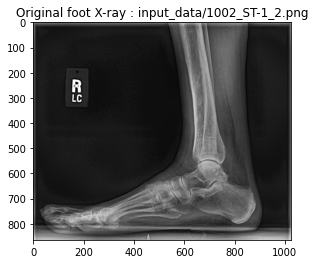

Final min_height is  615
Final max_height is  759


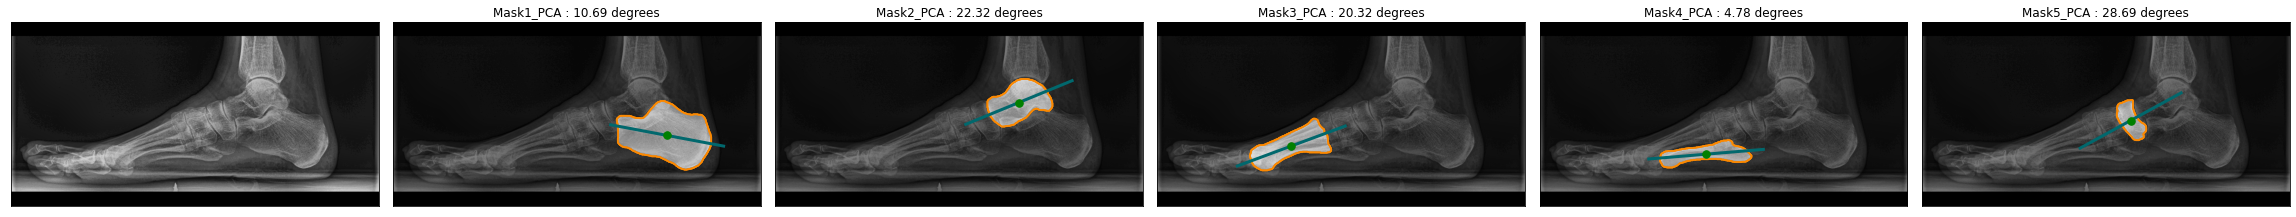

********************************************************************************************************************************************************************************************************


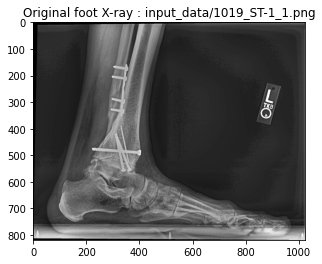

Final min_height is  562
Final max_height is  693


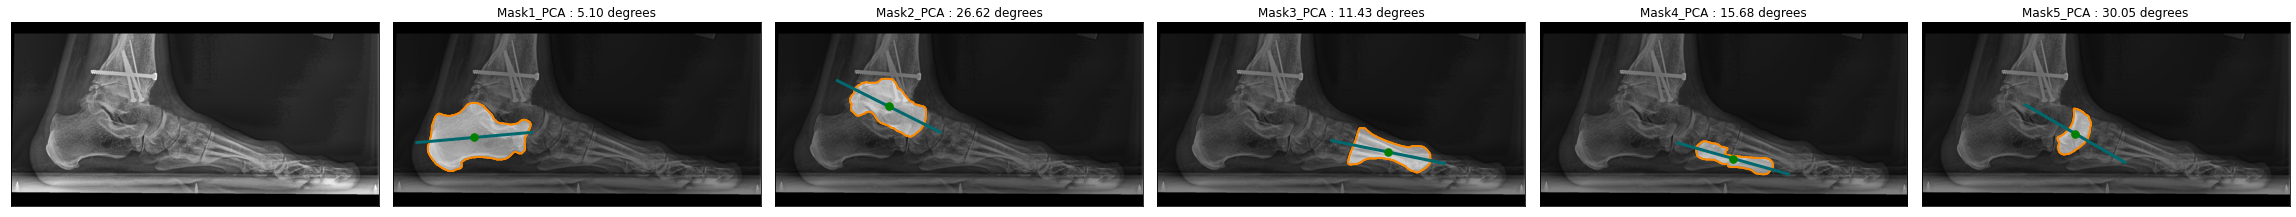

********************************************************************************************************************************************************************************************************


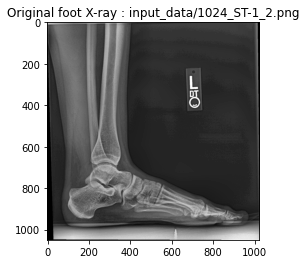

Final min_height is  744
Final max_height is  895


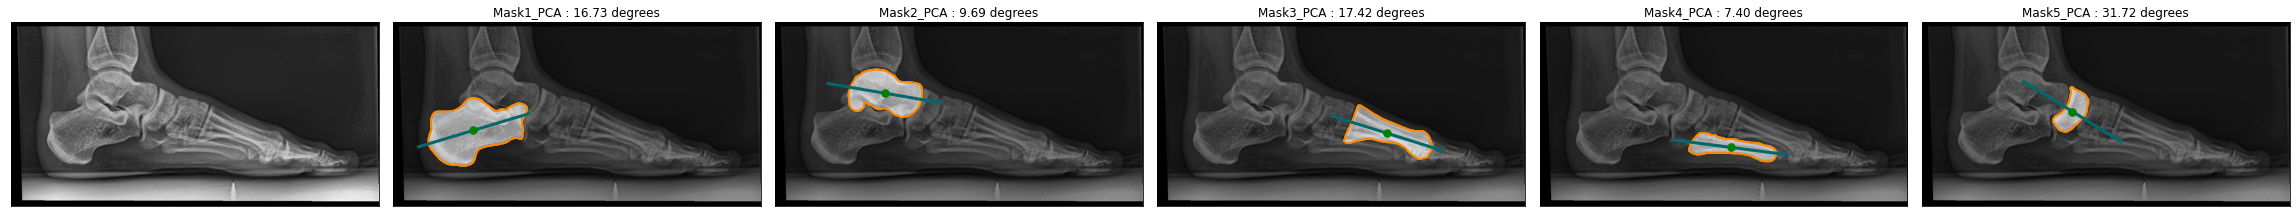

********************************************************************************************************************************************************************************************************


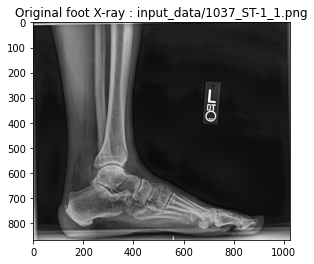

Final min_height is  625
Final max_height is  753


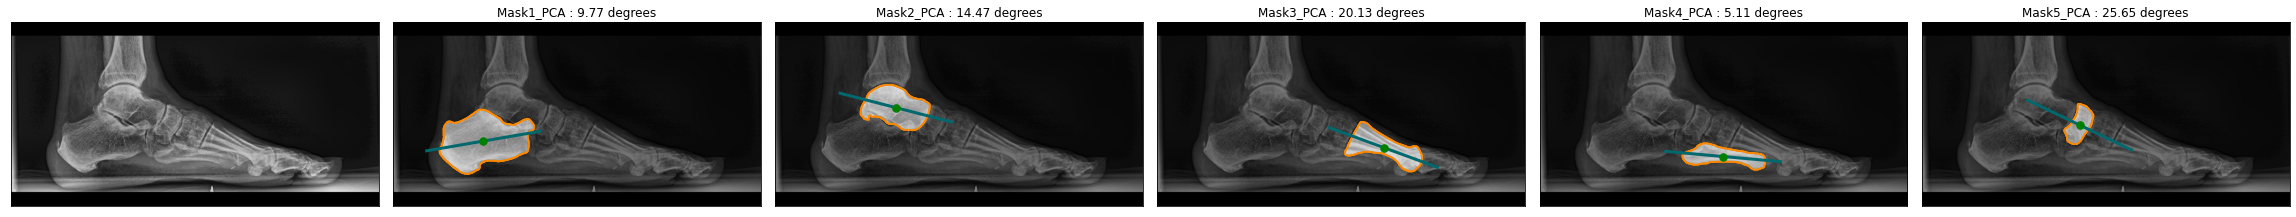

********************************************************************************************************************************************************************************************************


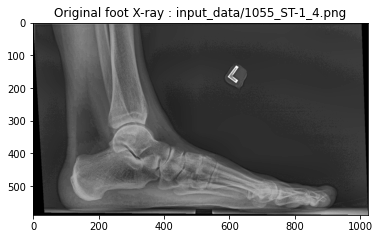

Final min_height is  372
Final max_height is  488


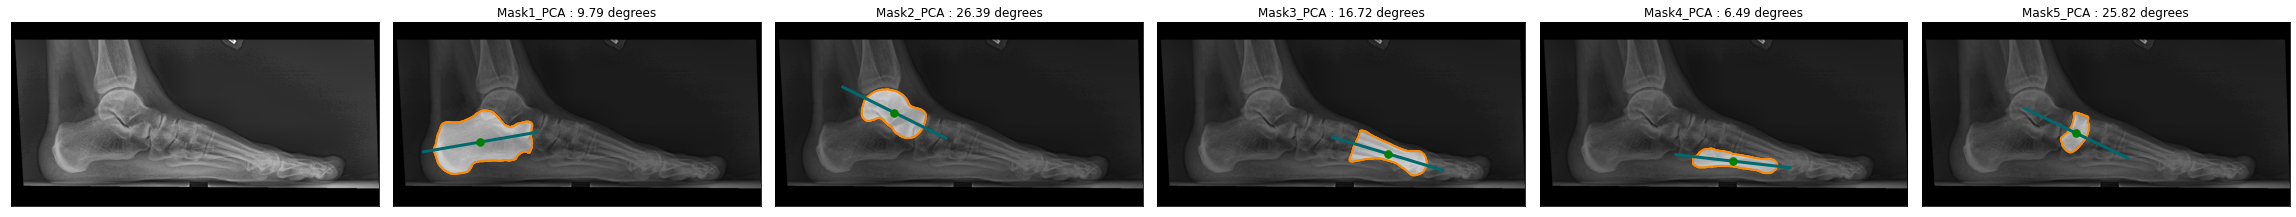

********************************************************************************************************************************************************************************************************


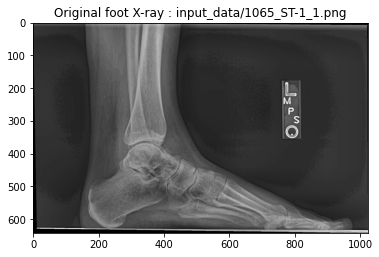

Final min_height is  419
Final max_height is  512


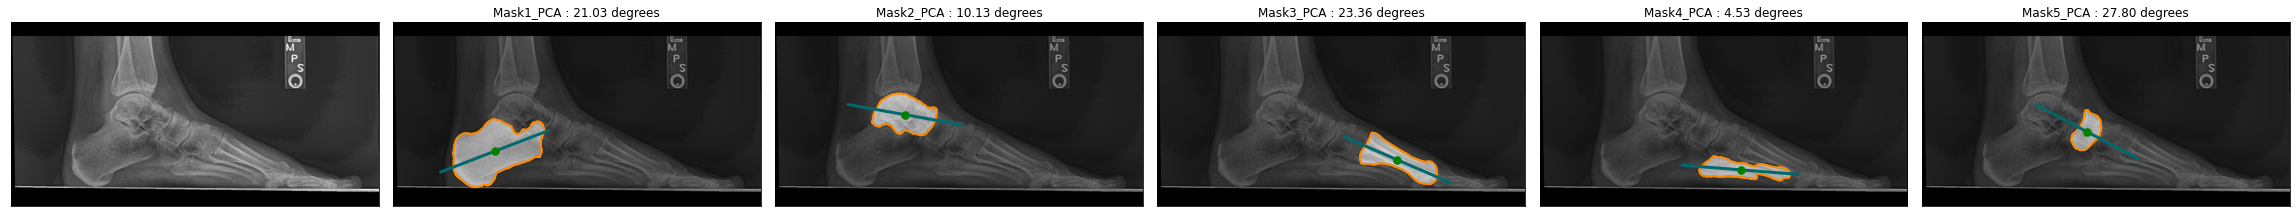

********************************************************************************************************************************************************************************************************


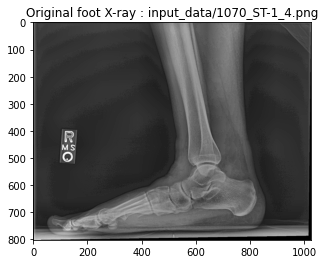

Final min_height is  574
Final max_height is  674


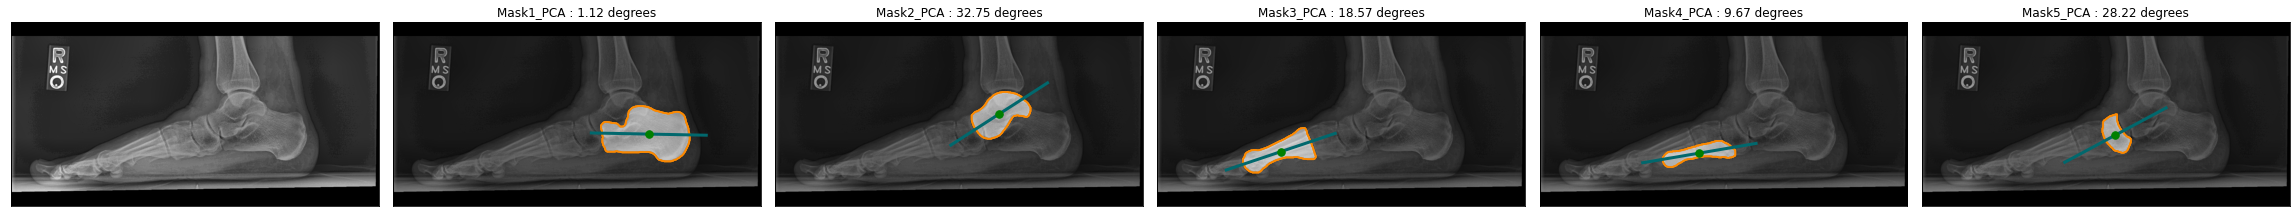

********************************************************************************************************************************************************************************************************


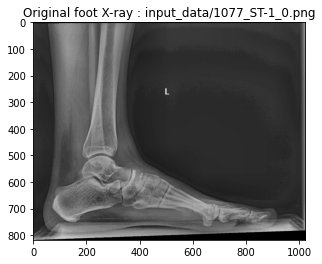

Final min_height is  557
Final max_height is  674


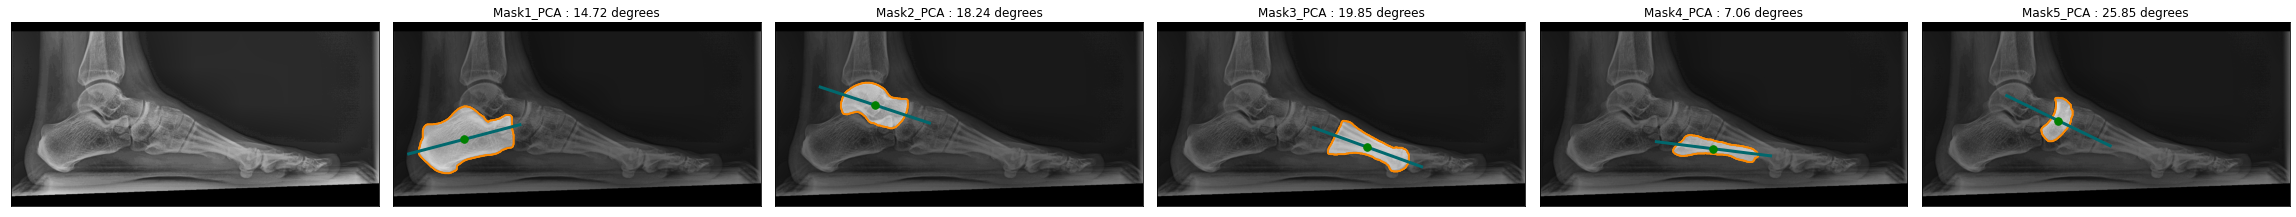

********************************************************************************************************************************************************************************************************


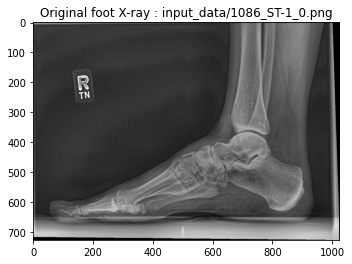

Final min_height is  422
Final max_height is  577


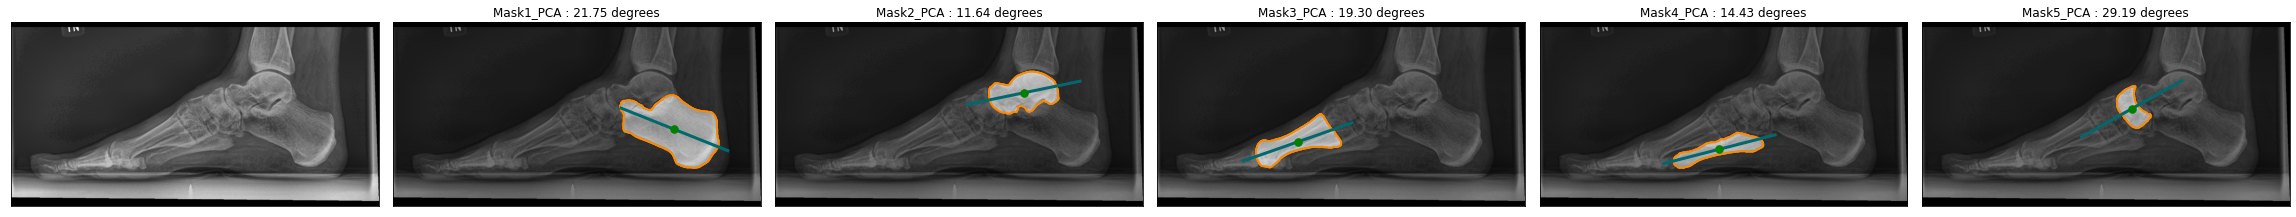

********************************************************************************************************************************************************************************************************


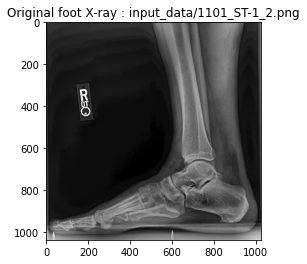

Final min_height is  731
Final max_height is  909


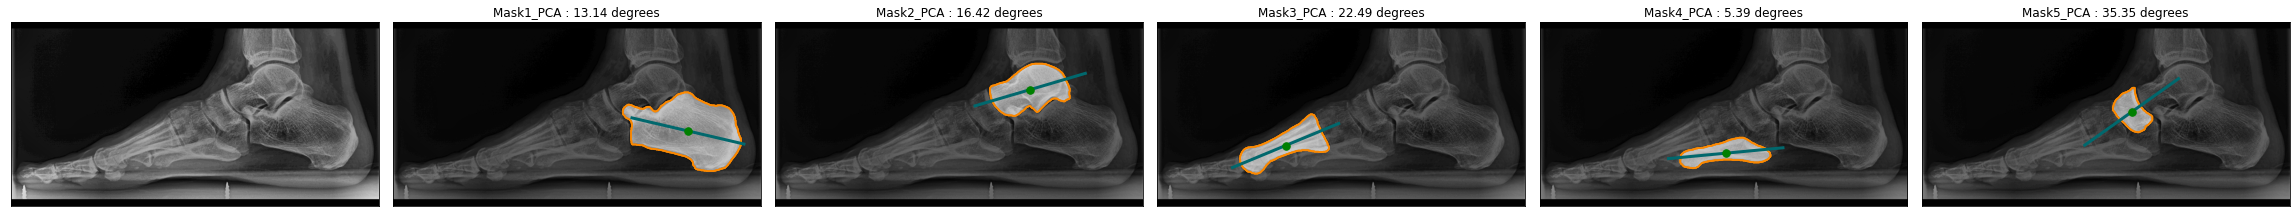

********************************************************************************************************************************************************************************************************


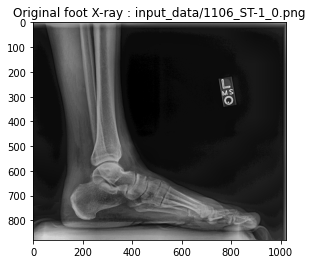

Final min_height is  618
Final max_height is  750


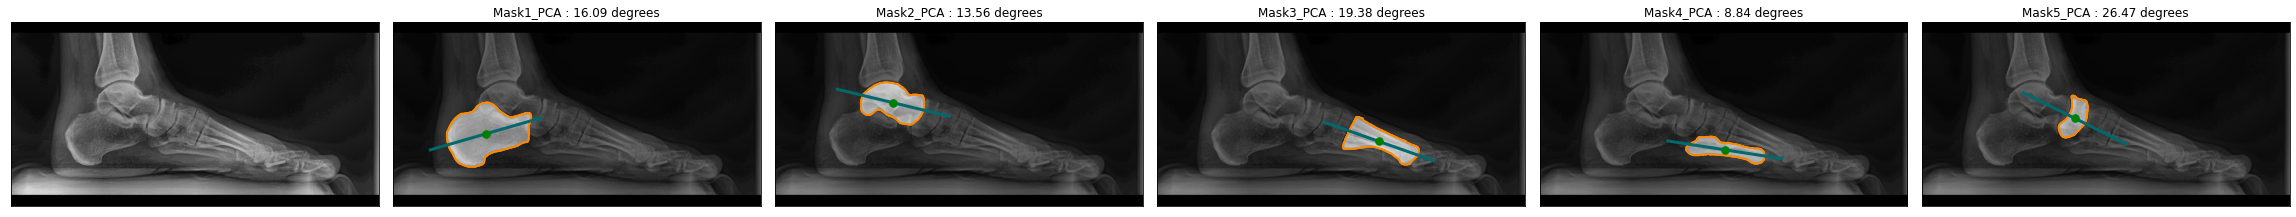

********************************************************************************************************************************************************************************************************


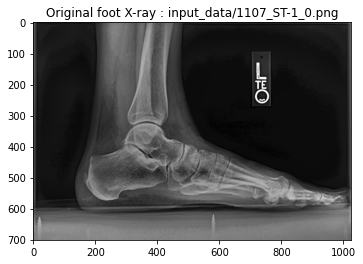

Final min_height is  391
Final max_height is  535


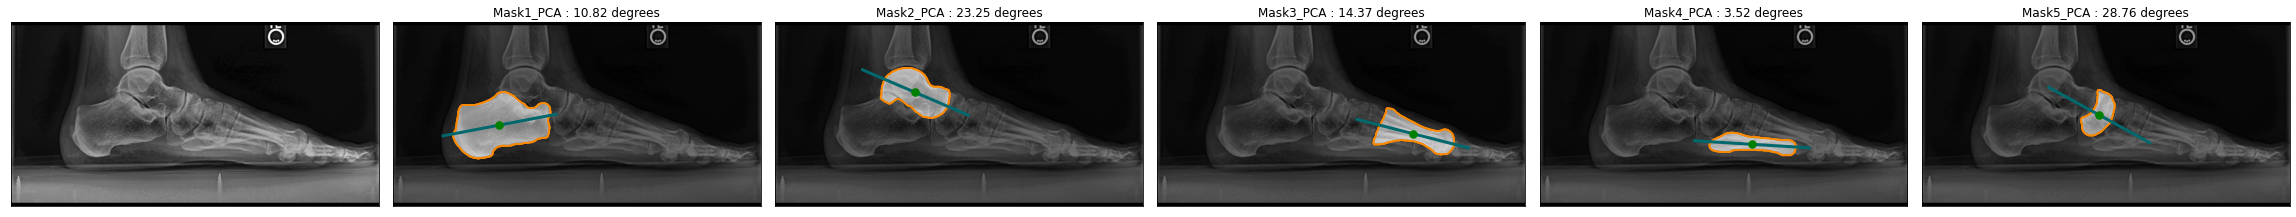

********************************************************************************************************************************************************************************************************


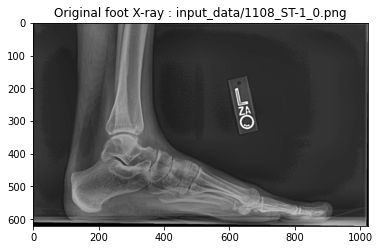

Final min_height is  393
Final max_height is  532


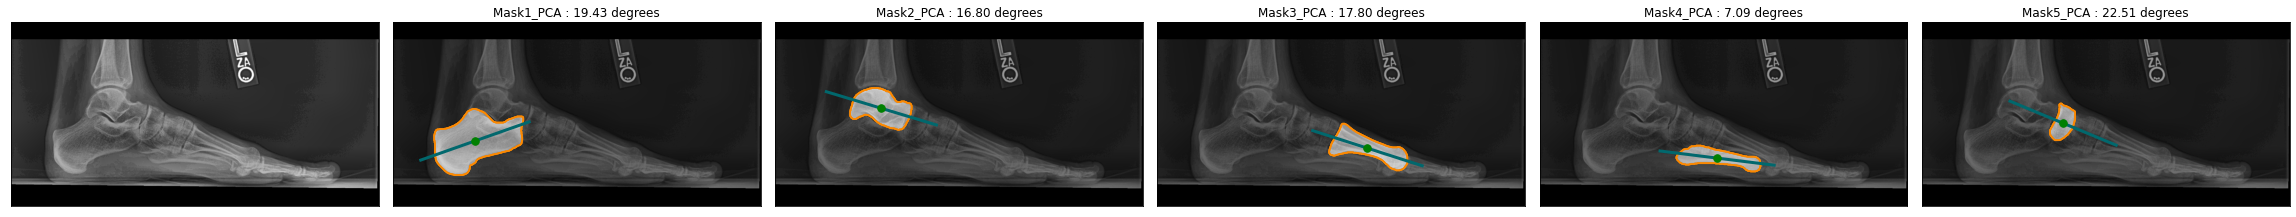

********************************************************************************************************************************************************************************************************


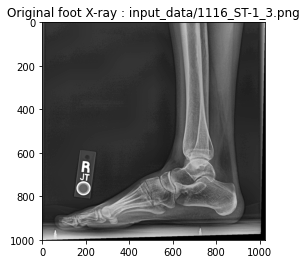

Final min_height is  686
Final max_height is  847


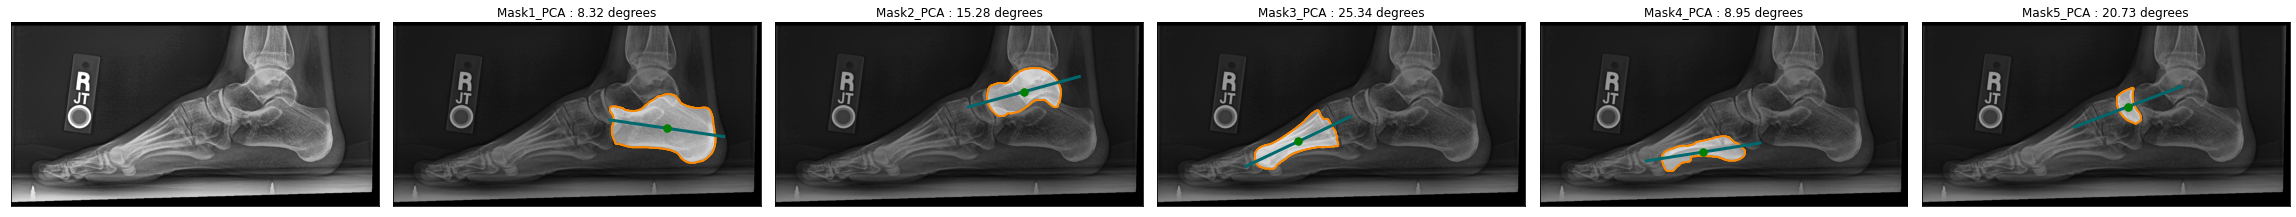

********************************************************************************************************************************************************************************************************


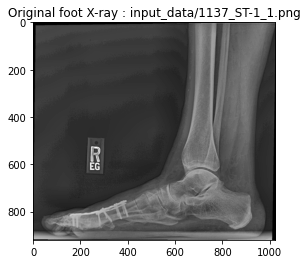

Final min_height is  684
Final max_height is  817


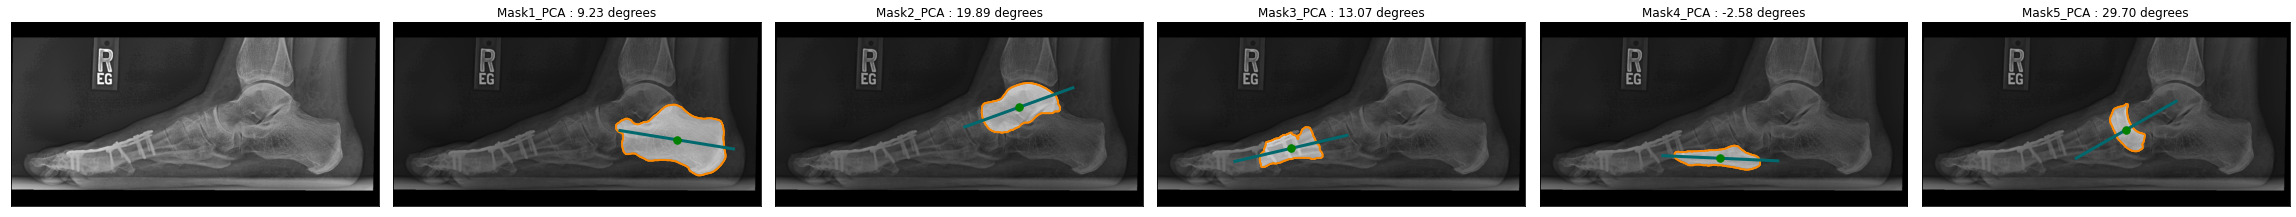

********************************************************************************************************************************************************************************************************


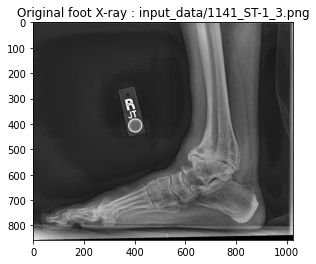

Final min_height is  586
Final max_height is  730


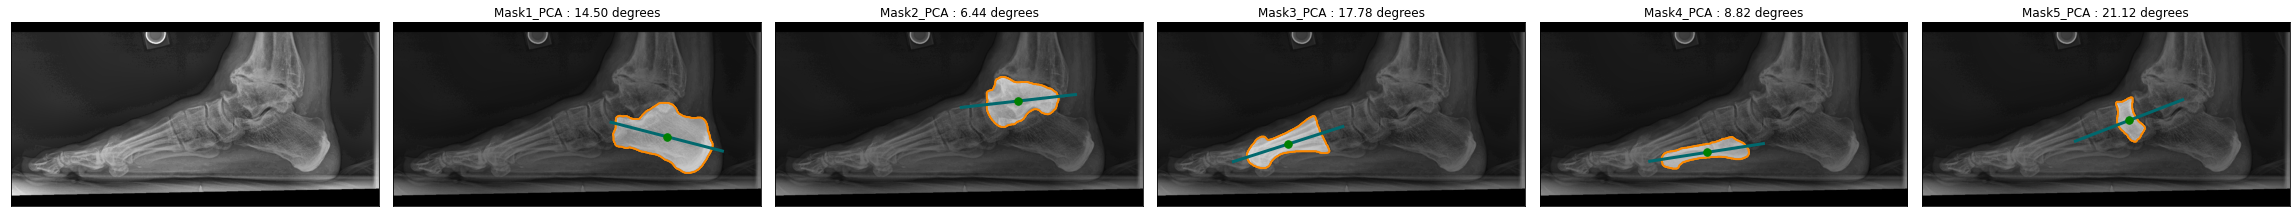

********************************************************************************************************************************************************************************************************


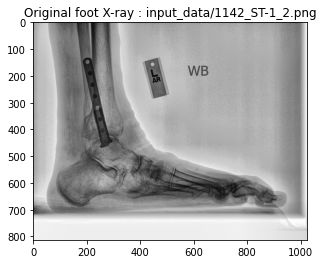

Final min_height is  492
Final max_height is  624


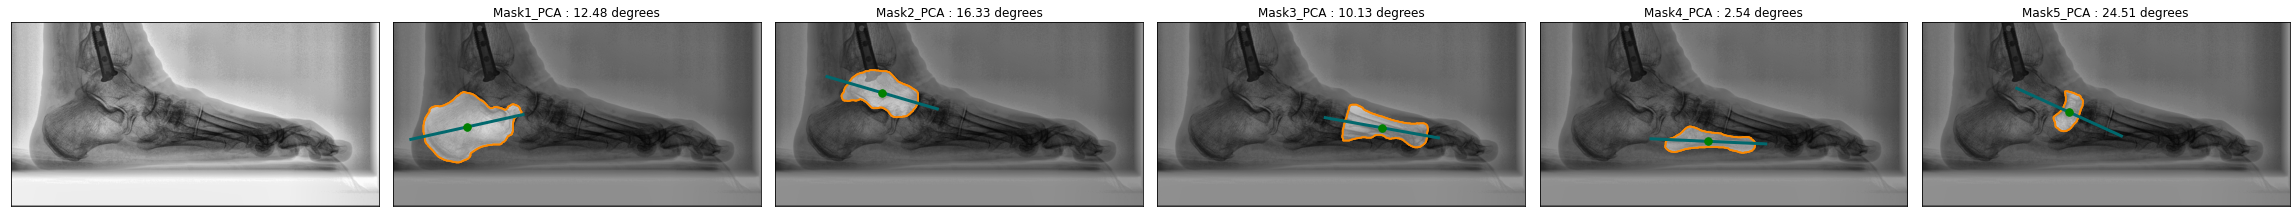

********************************************************************************************************************************************************************************************************


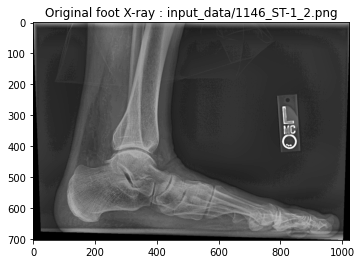

Final min_height is  482
Final max_height is  610


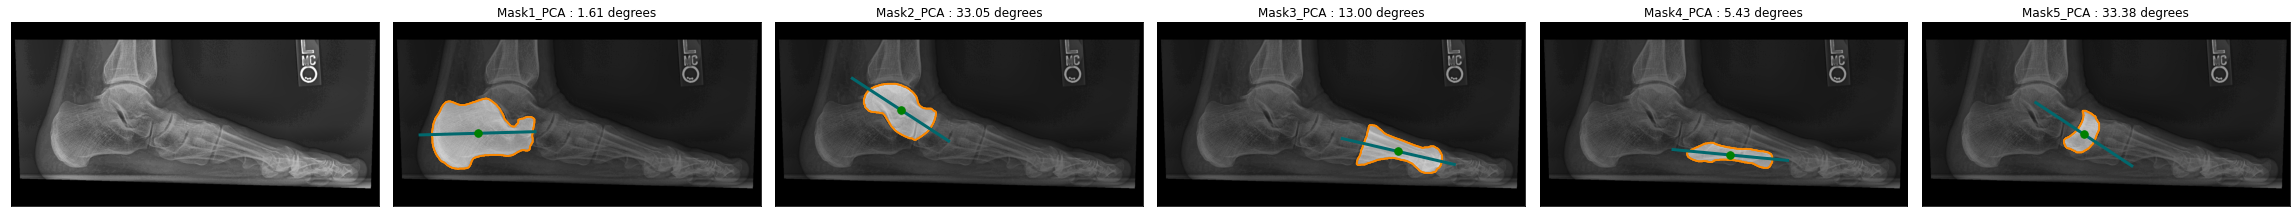

********************************************************************************************************************************************************************************************************


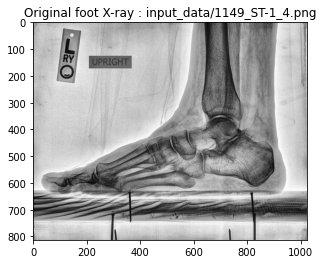

Final min_height is  413
Final max_height is  538


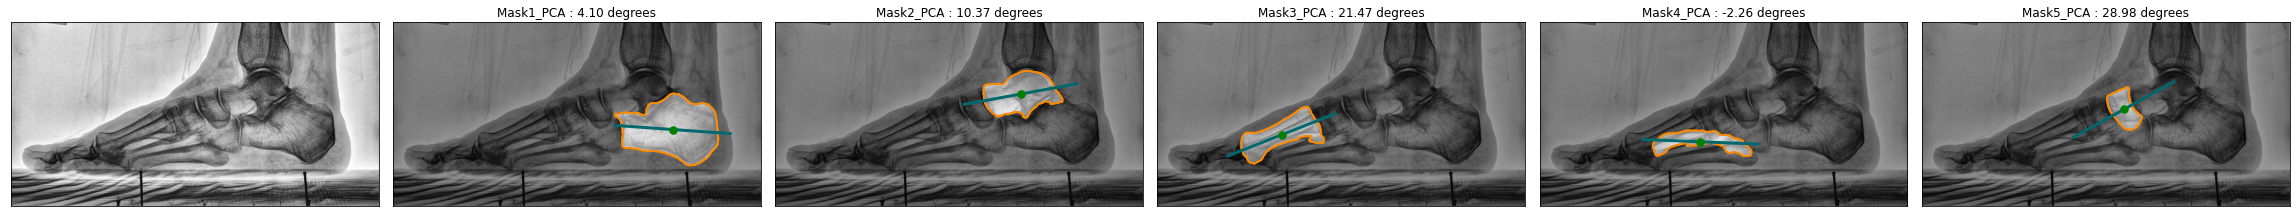

********************************************************************************************************************************************************************************************************


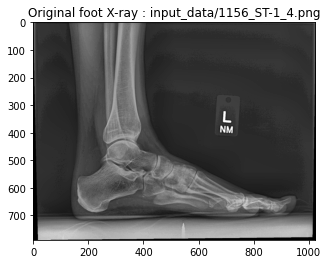

Final min_height is  484
Final max_height is  636


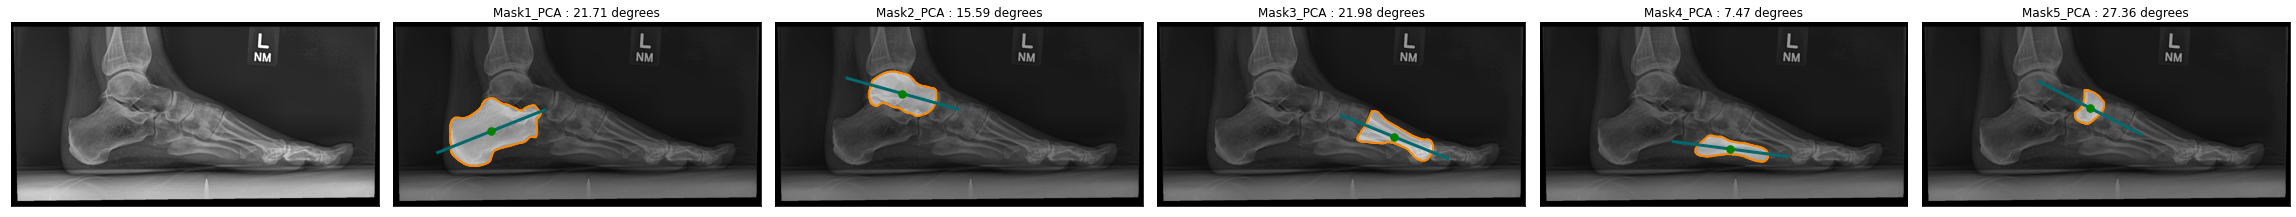

********************************************************************************************************************************************************************************************************


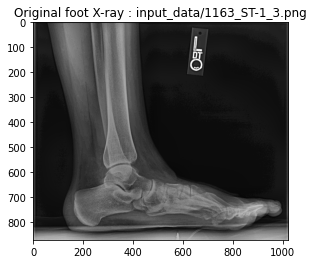

Final min_height is  631
Final max_height is  734


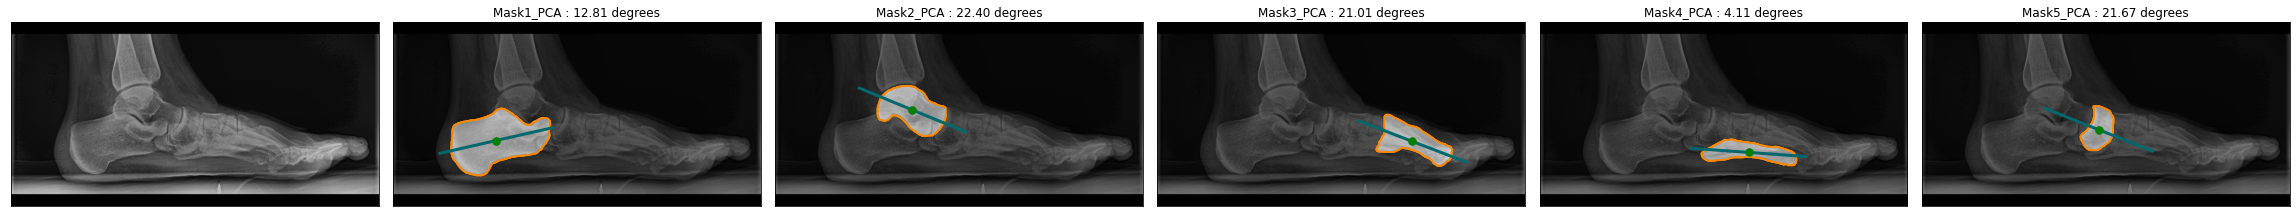

********************************************************************************************************************************************************************************************************


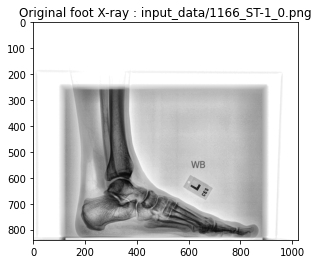

Final min_height is  647
Final max_height is  755


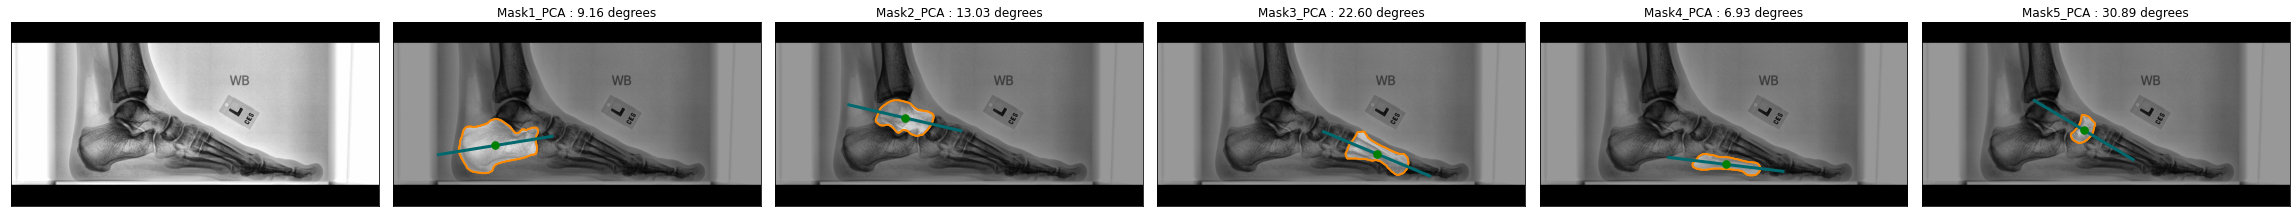

********************************************************************************************************************************************************************************************************


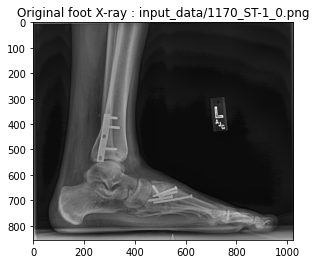

Final min_height is  612
Final max_height is  737


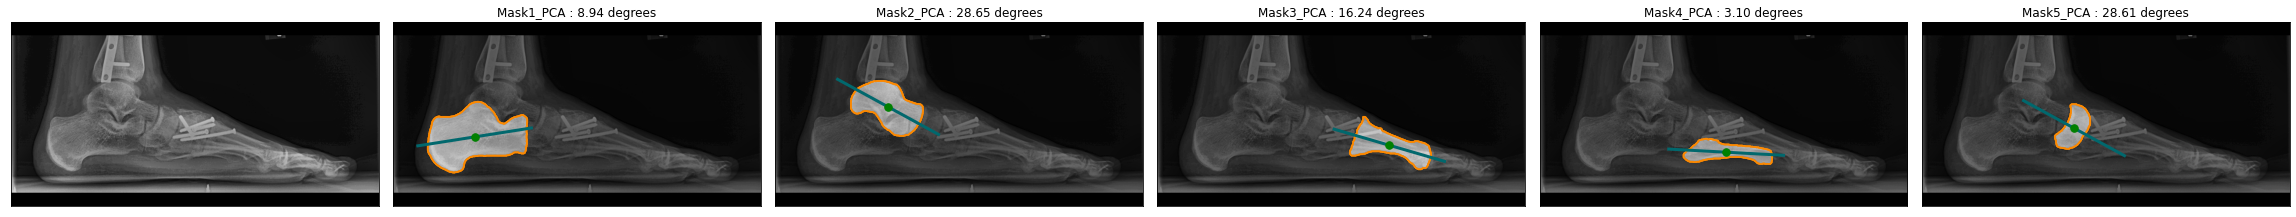

********************************************************************************************************************************************************************************************************


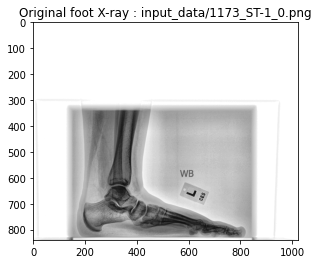

Final min_height is  671
Final max_height is  762


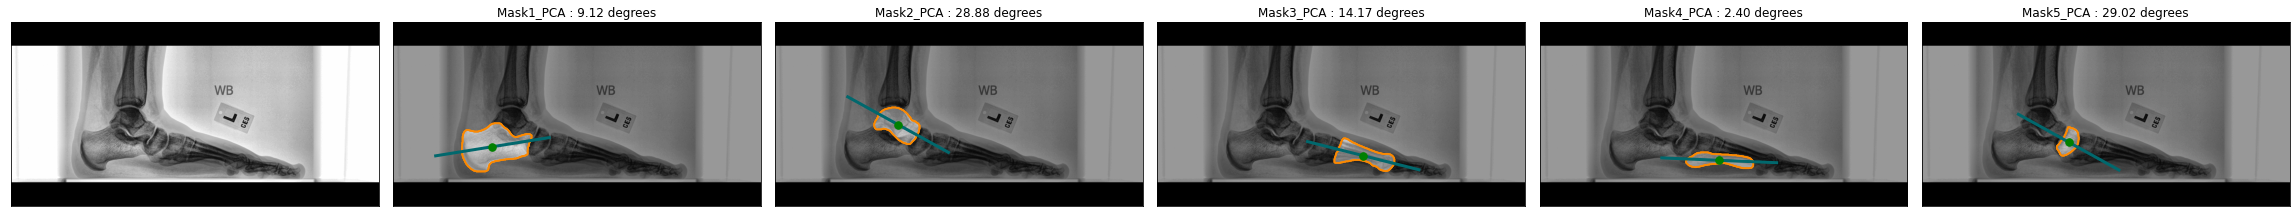

********************************************************************************************************************************************************************************************************


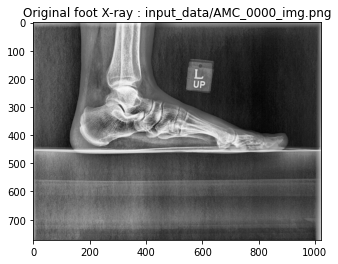

Final min_height is  279
Final max_height is  381


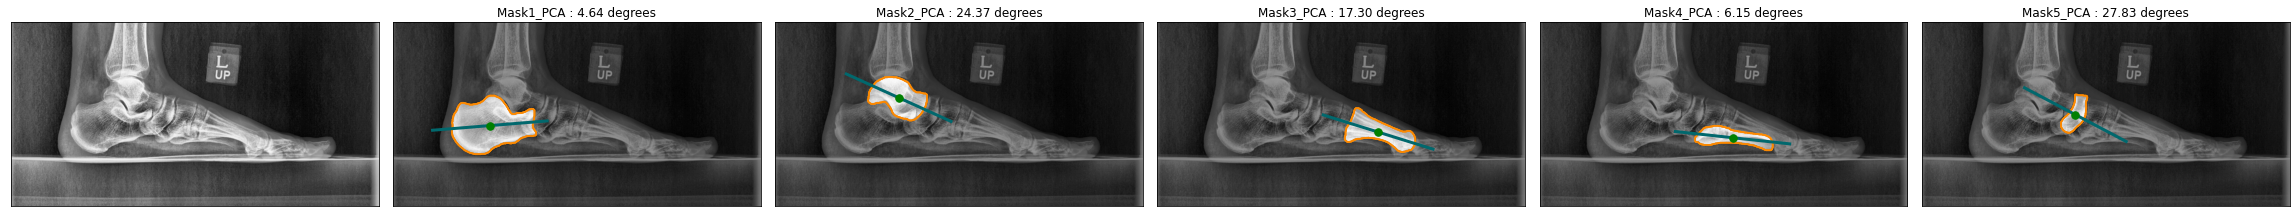

********************************************************************************************************************************************************************************************************


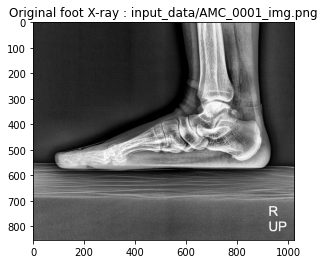

Final min_height is  371
Final max_height is  484


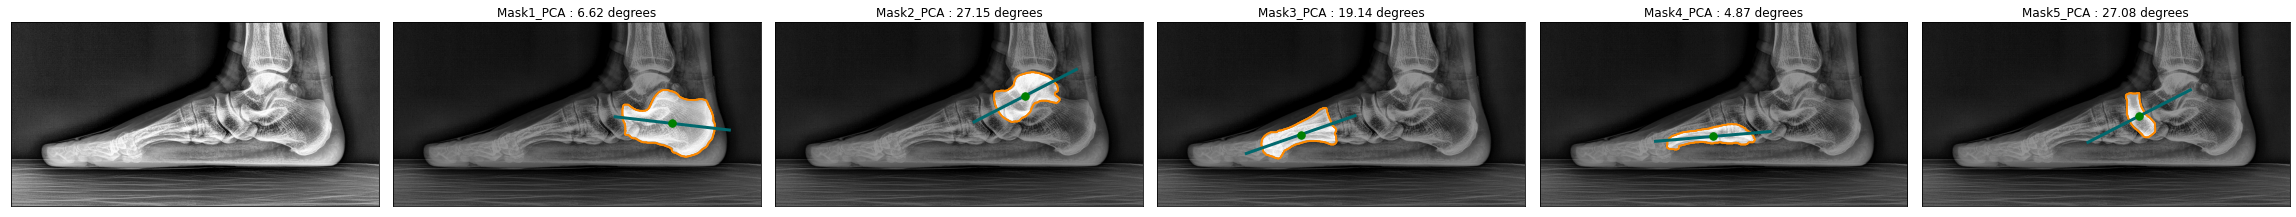

********************************************************************************************************************************************************************************************************


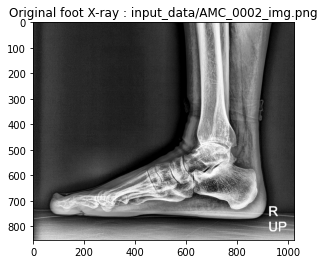

Final min_height is  529
Final max_height is  676


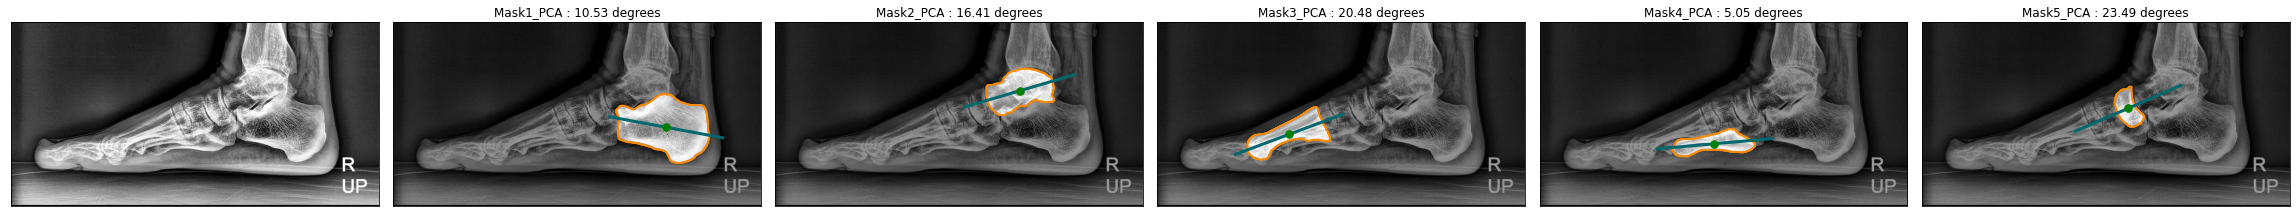

********************************************************************************************************************************************************************************************************


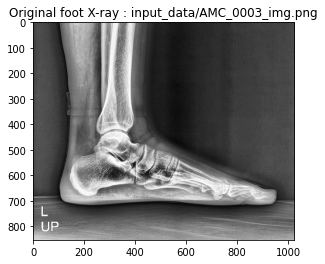

Final min_height is  485
Final max_height is  631


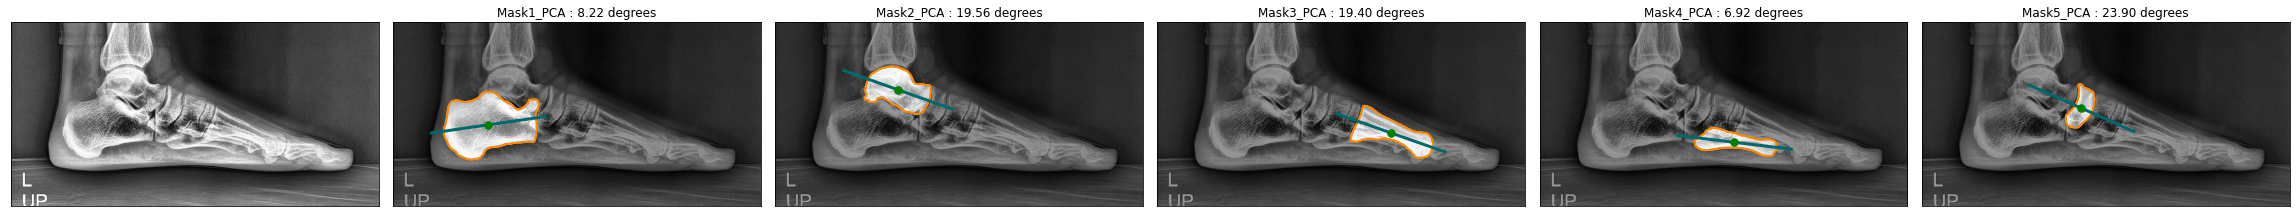

********************************************************************************************************************************************************************************************************


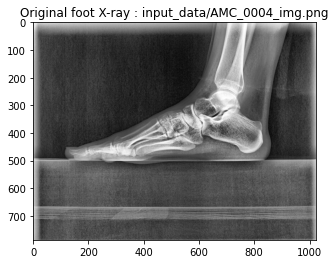

Final min_height is  296
Final max_height is  446


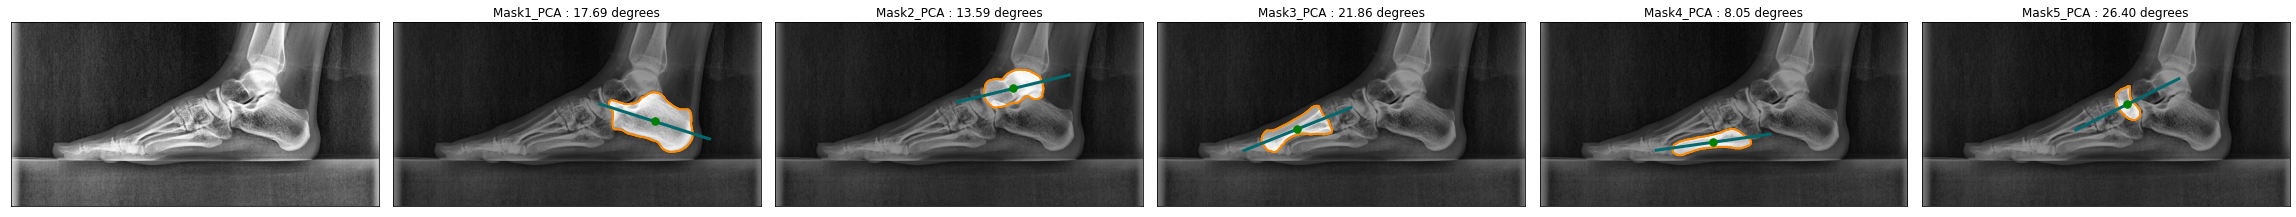

********************************************************************************************************************************************************************************************************


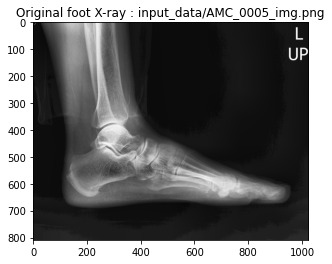

Final min_height is  437
Final max_height is  590


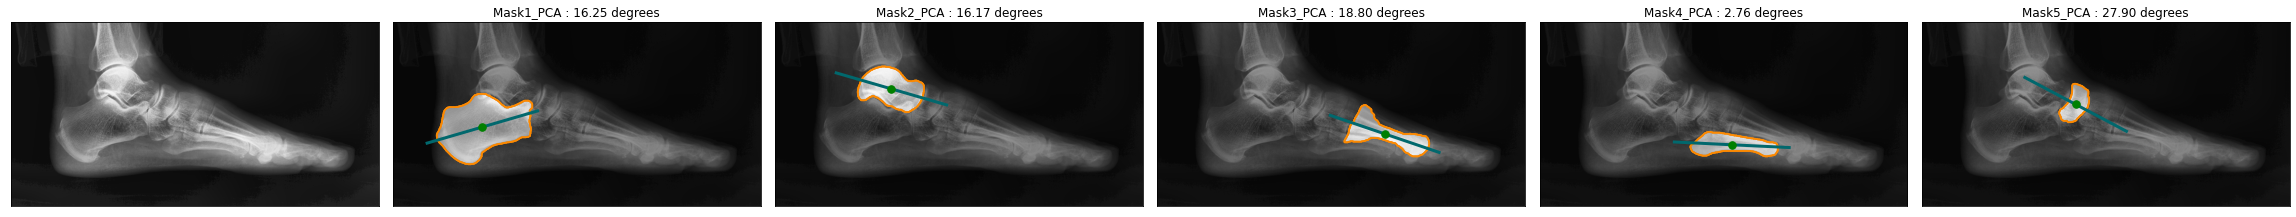

********************************************************************************************************************************************************************************************************


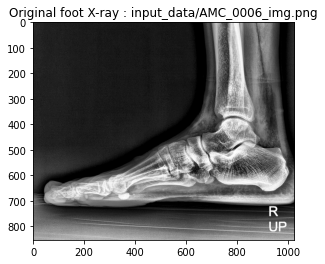

Final min_height is  448
Final max_height is  620


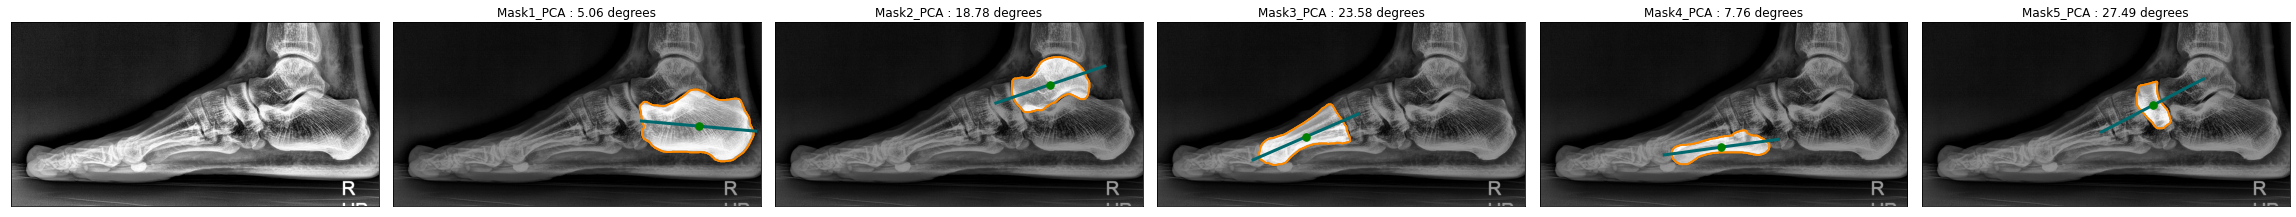

********************************************************************************************************************************************************************************************************


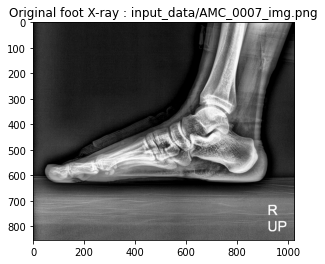

Final min_height is  393
Final max_height is  545


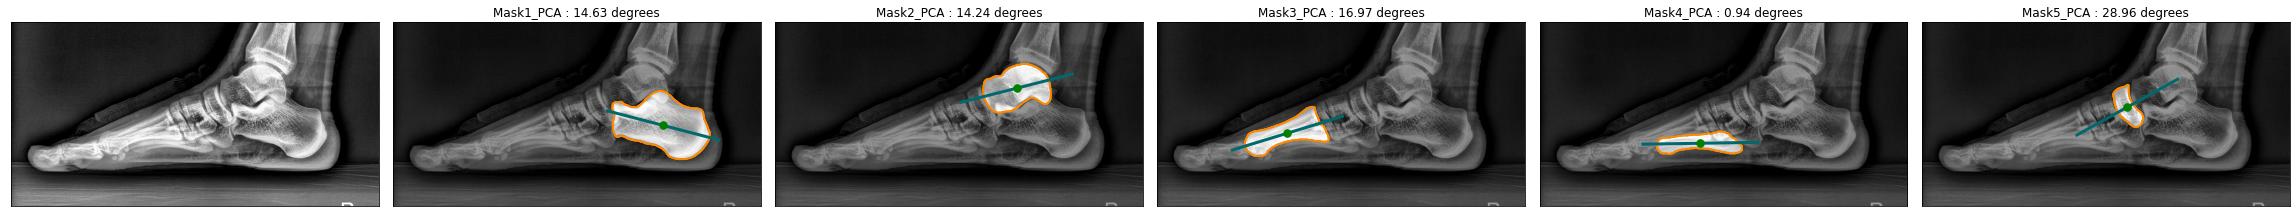

********************************************************************************************************************************************************************************************************


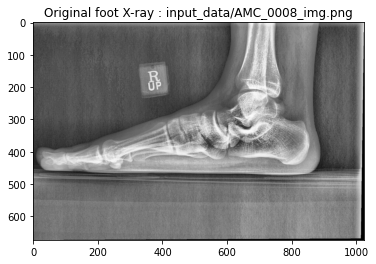

Final min_height is  275
Final max_height is  387


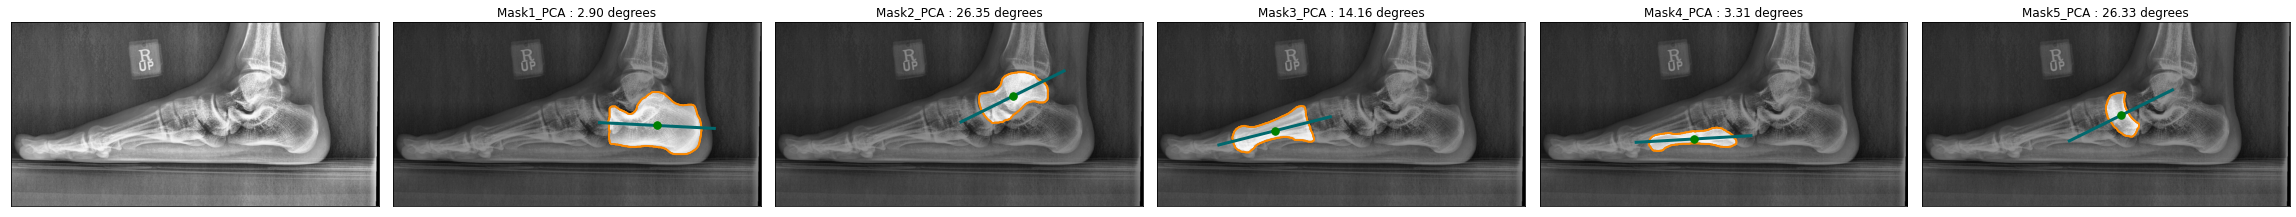

********************************************************************************************************************************************************************************************************


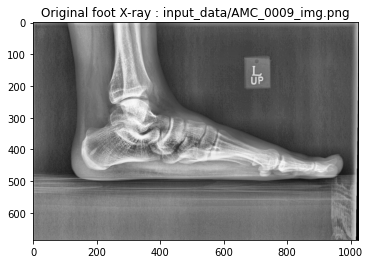

Final min_height is  301
Final max_height is  421


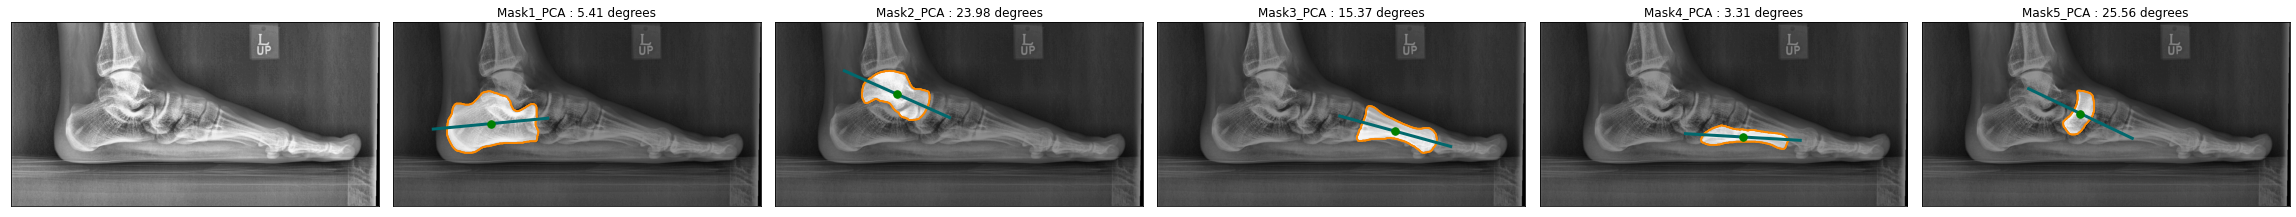

********************************************************************************************************************************************************************************************************


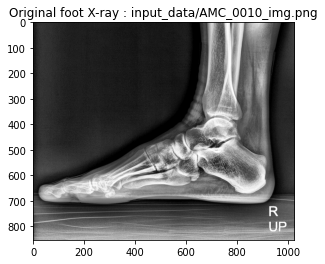

Final min_height is  435
Final max_height is  615


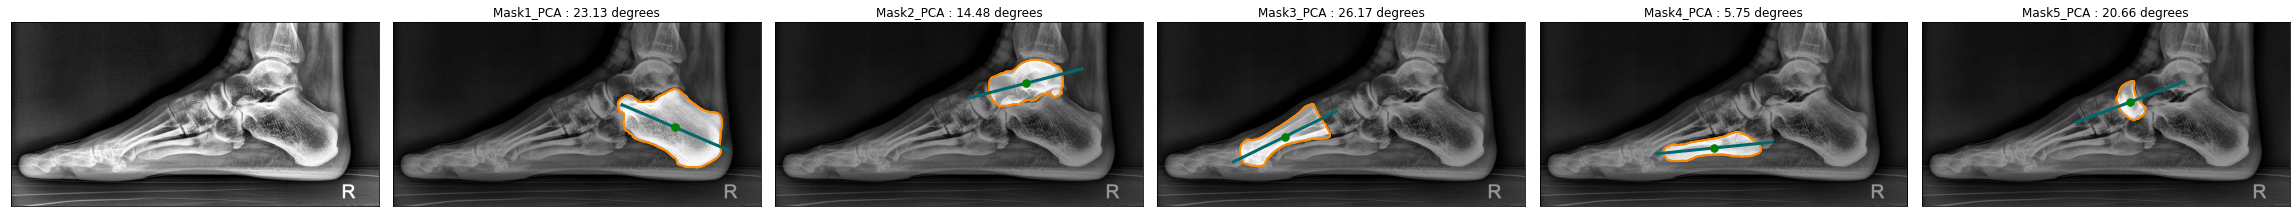

********************************************************************************************************************************************************************************************************


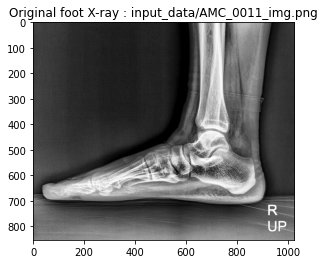

Final min_height is  485
Final max_height is  609


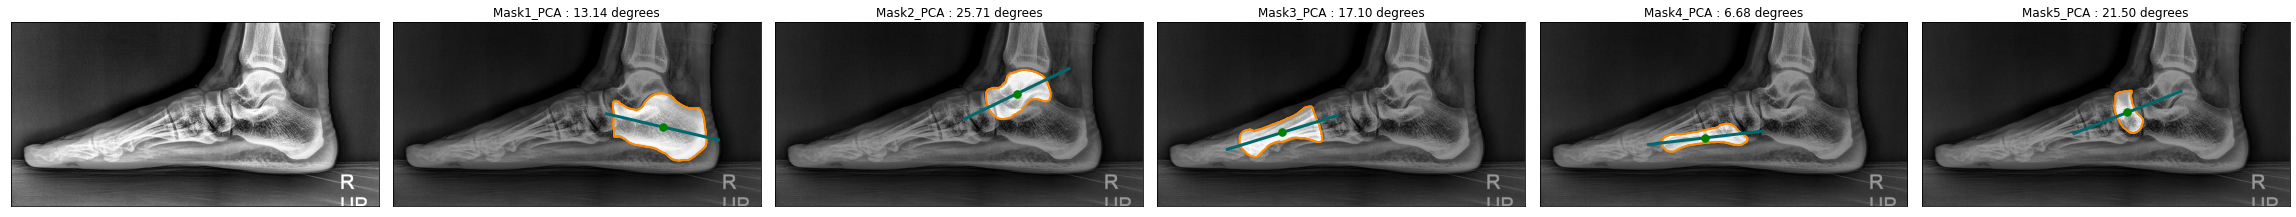

********************************************************************************************************************************************************************************************************


In [13]:
# 1. 이미지에 대한 각 마스크의 최대 값 찾기  
for idx, batch in enumerate(etest_loader) : 
    x = batch['image']
    y = batch['seg']
    fname = batch['fname']
    plt.imshow(x[0,0],cmap='gray')
    plt.title(f'Original foot X-ray : {fname[0]}')
    plt.show()  

    yhat = net(x.cuda()) 
    min_height = 2000 
    max_height = 0 
    image_height = x[0,0].shape[0]

    for idx in range(5) :     
        local_min = (yhat[0][0,idx]==True).nonzero(as_tuple=True)[0].median().item() 
        local_max = (yhat[0][0,idx]==True).nonzero(as_tuple=True)[0].median().item() 
        min_height = min(min_height, local_min)
        max_height = max(max_height, local_max)
    
    # print("Final min_height is ", min_height)
    # print("Final max_height is ", max_height)
    
    center_height = (min_height+max_height)//2
    x_resize = x[:,:,center_height-256:center_height+256,:]
    pad = 512 - x_resize.shape[2]
    top = pad//2
    bottom = pad-top
    x_resize = F.pad(x_resize,(0, 0, top, bottom))
    
    yhat = net(x_resize.cuda())
    yhat = yhat[0].cpu().detach().numpy().round()
    yhat = yhat.astype(bool)
    
    for i in range(5):            
        yhat[0,i] = skimage.morphology.remove_small_objects(yhat[0,i], min_size=500, connectivity=2)
    yhat = yhat.astype(int)
    visualize(image=x_resize[0].cpu(), mask1=yhat[0,0], mask2=yhat[0,1], mask3=yhat[0,2], mask4=yhat[0,3], mask5=yhat[0,4])
        
    print("*"*200)